# Compare behavior cloning

This notebook allows the visual comparison of various behavior cloning controllers, as shown in their verify runs. The notebook starts with an experiment that lists several bc verify type experiments. It is assumed that those experiments had been run before this notebook is running, because it is building on the results of those experiments. 

In [1]:
import sys
sys.path.append("..")

from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"

import pathlib
import pprint
import copy 

import matplotlib.pyplot as plt
# fixing the fact that it defaults to Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import numpy as np
from robot.al5d_position_controller import RobotPosition


In [2]:
# *** Initialize the variables with default values 
# *** This cell should be tagged as parameters     
# *** If papermill is used, some of the values will be overwritten 

# If it is set to true, the exprun will be recreated from scratch
creation_style = "exist-ok"

# If not None, set an external experiment path
external_path = None

# If not None, set an output path
data_path = None

experiment = "behavior_cloning"
run = None
# run = "bc_compare_00"

# **** The settings below are used to debug a particular run in flow 
# **** They do not affect the run of the flow, 
# **** because they are going to be overwritten by papermill when run in a flow
creation_style = "exist-ok"
data_path = "c:/Users/lotzi/Work/_Data/BerryPicker-Flows/BC-touch-apple/result"
external_path = "c:/Users/lotzi/Work/_Data/BerryPicker-Flows/BC-touch-apple/exprun"
experiment = "behavior_cloning"
# run = "_flow_bc_compare_0001"
run = "_flow_bc_compare"



In [3]:
if external_path:
    external_path = pathlib.Path(external_path)
    assert external_path.exists()
    Config().set_exprun_path(external_path)
    Config().copy_experiment("sensorprocessing_conv_vae")
    Config().copy_experiment("robot_al5d")
    Config().copy_experiment("demonstration")
    Config().copy_experiment("behavior_cloning")
if data_path:
    data_path = pathlib.Path(data_path)
    assert data_path.exists()
    Config().set_results_path(data_path)

exp = Config().get_experiment(experiment, run)
pprint.pprint(exp)

verification_run_exps = {}
for expname in exp["bc_verification_runs"]:
    verexp = Config().get_experiment(experiment, expname)
    verification_run_exps[expname] = verexp

***ExpRun**: Loading pointer config file:
	C:\Users\lotzi\.config\BerryPicker\mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	c:\Users\lotzi\Work\_Config\BerryPicker\cfg\settings.yaml
***ExpRun**: Experiment config path changed to c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\exprun
***ExpRun**: Experiment sensorprocessing_conv_vae copied to
c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\exprun\sensorprocessing_conv_vae
***ExpRun**: Experiment robot_al5d copied to
c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\exprun\robot_al5d
***ExpRun**: Experiment demonstration copied to
c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\exprun\demonstration
***ExpRun**: Experiment behavior_cloning copied to
c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\exprun\behavior_cloning
***ExpRun**: Experiment data path changed to c:\Users\lotzi\Work\_Data\BerryPicker-Flows\BC-touch-apple\result
***ExpRun**: Configuration for exp

In [4]:
def generate_comparisons(verification_run_exps, teacher_name, pred_name, fileroot):
    # load the saved data from the verifications
    teacher_np = None
    preds_nps = {}
    mylabels = {}
    for name in verification_run_exps:
        verexp = verification_run_exps[name]
        mylabels[name] = verexp["name"]
        if teacher_np is None:
            teacher_path = pathlib.Path(verexp.data_dir(), teacher_name)
            teacher_np = np.load(teacher_path)
        pred_path =  pathlib.Path(verexp.data_dir(), pred_name)
        pred_np = np.load(pred_path)
        preds_nps[name] = pred_np

    fig, axs = plt.subplots(2,3, figsize=(8, 6))
    # for i in range(bcexp["control_size"]):
    for i in range(6):
        ax = axs[i//3, i%3]
        ax.set_ylim(-0.1, 1.1)
        for name in preds_nps:
            label = mylabels[name]
            if len(preds_nps[name].shape)== 3:
                ax.plot(preds_nps[name][:,0,i], label=f"{label}")
            else:
                ax.plot(preds_nps[name][:,i], label=f"{label}")
        ax.plot(teacher_np[:,i], label="ground truth")
        if i==0: 
            handles, labels = ax.get_legend_handles_labels()
            fig.legend(handles, labels, ncol=1+len(verification_run_exps),
                bbox_to_anchor=(0.5, 0), loc="upper center")
        ax.set_title(RobotPosition.FIELDS[i])
    plt.tight_layout()
    compare_pdf_path = pathlib.Path(exp.data_dir(), f"{fileroot}.pdf")
    plt.savefig(compare_pdf_path, bbox_inches='tight')
    compare_jpg_path = pathlib.Path(exp.data_dir(), f"{fileroot}.jpg")
    plt.savefig(compare_jpg_path, bbox_inches='tight')

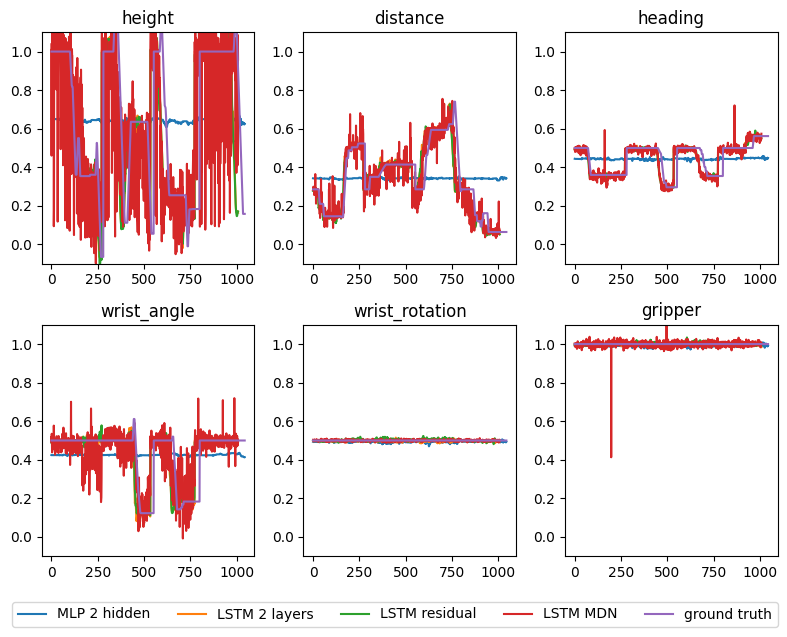

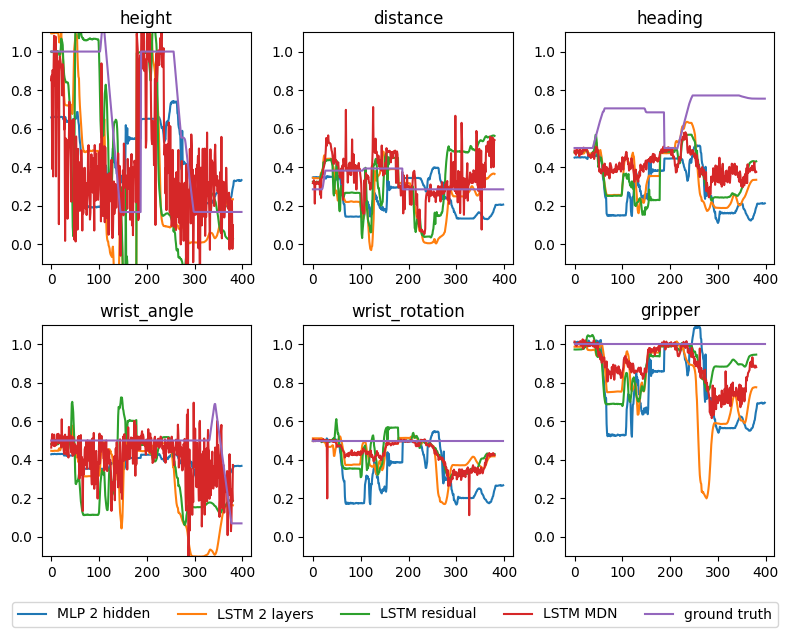

In [5]:
generate_comparisons(verification_run_exps, "teaforce_teacher_traindata.npy", "teaforce_predicted_traindata.npy", "comparison_train")
generate_comparisons(verification_run_exps, "teaforce_teacher_validdata.npy", "teaforce_predicted_validdata.npy", "comparison_verification")